In [414]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from scipy.optimize import minimize
from itertools import combinations
import tabulate

from climada.entity import Exposures
from climada.entity.impact_funcs.trop_cyclone import ImpfSetTropCyclone

from climada.engine import ImpactCalc

from climada.hazard import TCTracks, Centroids, TropCyclone

from climada.util.api_client import Client
import climada.util.yearsets as yearsets


# Parameters


In [415]:
# The company data file name
cpnys_file_name = 'Data/Company data/Company examples & locations.xlsx'

# The company reference column
company_ref = 'Distribution'

# Exclude companies based on column values
exclude_companies = None # {'Distribution': ['Local']}

# Make all the companies have the same asset value
all_same_asset_value = 1

# Give the coverage limit and deductible for all companies
# coverage_limit should in prct of the asset value in range [50, 100] %%!
# deductible should be in prct of the asset value in range [0, 10] %%!
coverage_limit =  50
deductible = 1

# The return period
return_period = 100

# The alpha value for the VaR and ES calculation ( Move to back)
alpha = 1/return_period

# The number of years to simulate
n_years = 10000



# Initiate Hazard object

In [416]:
# Make a dictionary and store historical, current and future hazard sets

# 
if not isinstance(haz_dict, dict):
    # Define time period
    time_periods = ['Historical', 'Current', 'Future']

    # Initialise the client
    client = Client()

    # Get the hazard set info
    hazard_type = 'tropical_cyclone'
    info_tc = client.list_dataset_infos('tropical_cyclone')
    print(client.get_property_values(info_tc))

    # Store the currrent hazard sets in a dictionary
    haz_dict = {time_period: None for time_period in time_periods}

    # Get the current hazard set
    properties_curr = {'model_name': 'STORM', 'spatial_coverage': 'global', 'name':'TC_global_0300as_STORM'}
    haz_dict[time_periods[1]] = client.get_hazard(hazard_type, properties=properties_curr)

    # Select future hazard set
    # Available future hazard sets
    available_fut_haz_sets = ['TC_global_0300as_STORM_CNRM-CM6-1-HR', 'TC_global_0300as_STORM_EC-Earth3P-HR'] # Available future hazard sets from the API 
    properties_fut = {'model_name': 'STORM', 'spatial_coverage': 'global', 'name': available_fut_haz_sets[0]}
    haz_dict[time_periods[2]] = client.get_hazard(hazard_type, properties=properties_fut)

    # Get the historical hazard set
    properties_curr = { 'spatial_coverage': 'global', 'event_type': 'observed' }
    haz_dict[time_periods[0]] = client.get_hazard(hazard_type, properties=properties_curr)
    #all_tracks = TCTracks.from_ibtracs_netcdf()
    #haz_dict[time_periods[0]] = TropCyclone.from_tracks(all_tracks, centroids=copy.deepcopy(haz_dict[time_periods[1]].centroids)) # Get centroids from current hazard set to speed up the computation

    # Plot the hazard set
    #haz_dict[time_periods[0]].plot_intensity(0) # Plot historical hazard set
    haz_dict[time_periods[0]].plot_intensity(0) # Plot current hazard set
    haz_dict[time_periods[1]].plot_intensity(0) # Plot current hazard set
    haz_dict[time_periods[2]].plot_intensity(0) # Plot future hazard set

# Impact functions

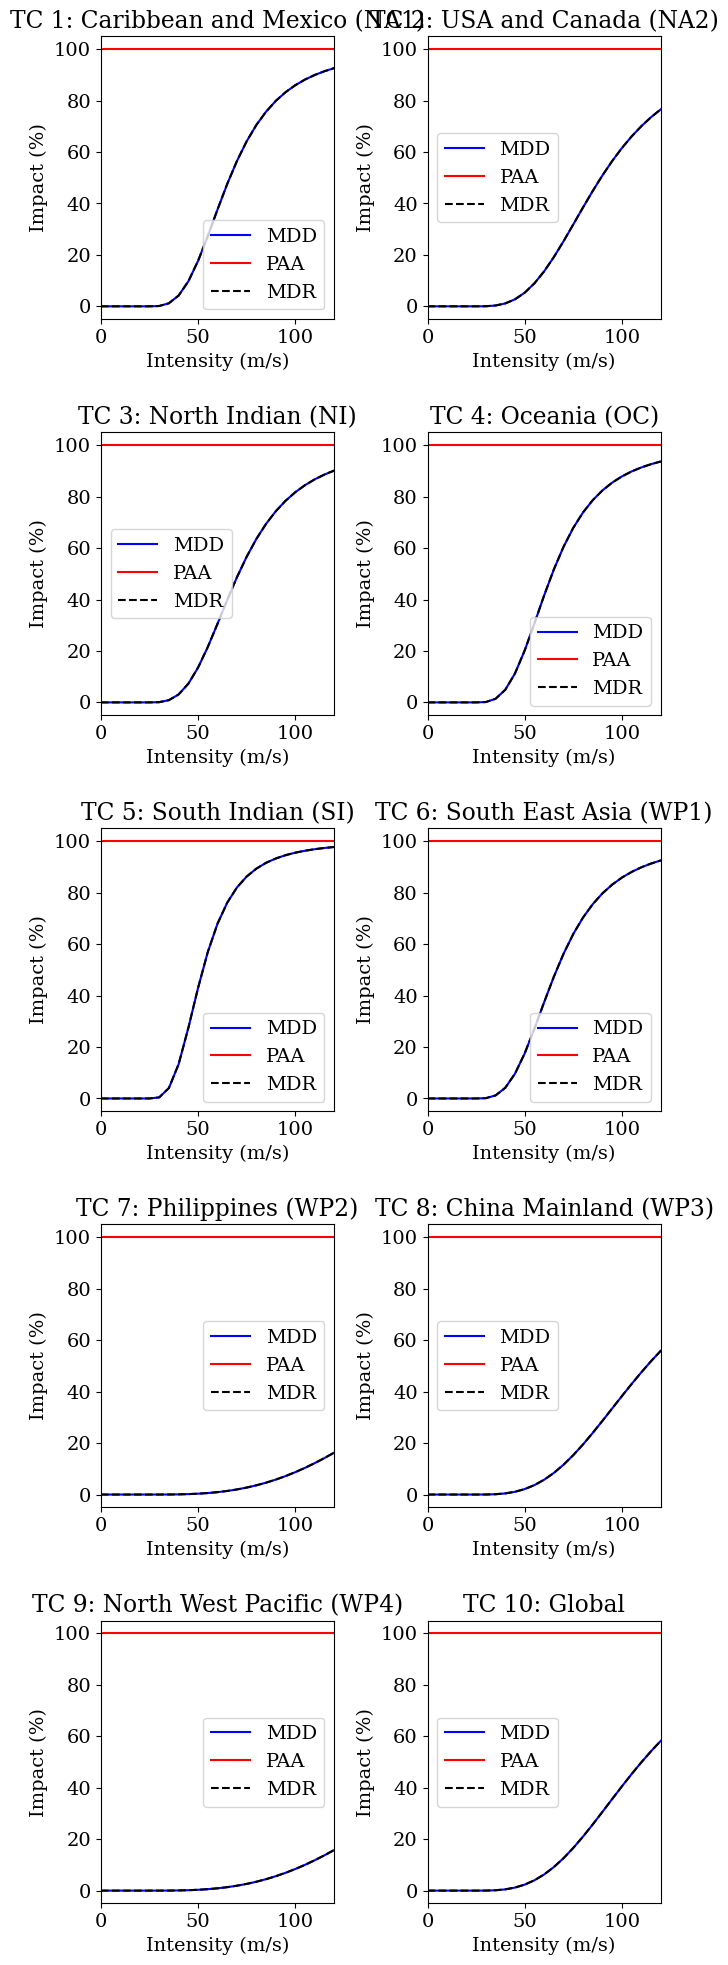

In [417]:
# generate the default calibrated TC impact functions for different regions
imp_fun_set_TC = ImpfSetTropCyclone.from_calibrated_regional_ImpfSet()

# plot all the impact functions
imp_fun_set_TC.plot()
# adjust the plots
plt.subplots_adjust(right=1., top=4., hspace=0.4, wspace=0.4)

# Exposure object


In [418]:
# Read the Excel file into a pandas DataFrame
exp_df = pd.read_excel(cpnys_file_name, usecols="A:J", sheet_name = 'Property values')  #Read only columns A to H  
# Remove the rows with no location
exp_df = exp_df[exp_df['Latitude'].notna()]
# Rename the columns using a dictionary
exp_df = exp_df.rename(columns={"Latitude": "latitude", "Longitude": "longitude", "Value (US$ billion)": "value"})

# See if the values should be equal to same value
if all_same_asset_value == 1:
    exp_df['value'] = all_same_asset_value

# Exclude companies
if exclude_companies is not None:
    for key in exclude_companies:
        for value in exclude_companies[key]:
            exp_df = exp_df[exp_df[key] != value]

In [419]:
# Map the impact function to the exposures assets 

## countries by region:
region_ids_cal = {'NA1': ['AIA', 'ATG', 'ARG', 'ABW', 'BHS', 'BRB', 'BLZ', 
                          'BMU', 'BOL', 'CPV', 'CYM', 'CHL', 'COL', 'CRI', 
                          'CUB', 'DMA', 'DOM', 'ECU', 'SLV', 'FLK', 'GUF', 
                          'GRD', 'GLP', 'GTM', 'GUY', 'HTI', 'HND', 'JAM', 
                          'MTQ', 'MEX', 'MSR', 'NIC', 'PAN', 'PRY', 'PER', 
                          'PRI', 'SHN', 'KNA', 'LCA', 'VCT', 'SXM', 'SUR', 
                          'TTO', 'TCA', 'URY', 'VEN', 'VGB', 'VIR'], \
                  'NA2': ['CAN', 'USA'], \
                  'NI': ['AFG', 'ARM', 'AZE', 'BHR', 'BGD', 'BTN', 'DJI', 
                         'ERI', 'ETH', 'GEO', 'IND', 'IRN', 'IRQ', 'ISR', 
                         'JOR', 'KAZ', 'KWT', 'KGZ', 'LBN', 'MDV', 'MNG', 
                         'MMR', 'NPL', 'OMN', 'PAK', 'QAT', 'SAU', 'SOM', 
                         'LKA', 'SYR', 'TJK', 'TKM', 'UGA', 'ARE', 'UZB', 
                         'YEM'], \
                  'OC': ['ASM', 'AUS', 'COK', 'FJI', 'PYF', 'GUM', 'KIR', 
                         'MHL', 'FSM', 'NRU', 'NCL', 'NZL', 'NIU', 'NFK', 
                         'MNP', 'PLW', 'PNG', 'PCN', 'WSM', 'SLB', 'TLS', 
                         'TKL', 'TON', 'TUV', 'VUT', 'WLF'], \
                  'SI': ['COM', 'COD', 'SWZ', 'MDG', 'MWI', 'MLI', 'MUS', 
                         'MOZ', 'ZAF', 'TZA', 'ZWE'], \
                  'WP1': ['KHM', 'IDN', 'LAO', 'MYS', 'THA', 'VNM'], \
                  'WP2': ['PHL'], \
                  'WP3': ['CHN'], \
                  'WP4': ['HKG', 'JPN', 'KOR', 'MAC', 'TWN'], 
                  'ROW': ['ALB', 'DZA', 'AND', 'AGO', 'ATA', 'AUT', 'BLR', 
                          'BEL', 'BEN', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 
                          'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'CMR', 'CAF', 
                          'TCD', 'CXR', 'CCK', 'COG', 'HRV', 'CUW', 'CYP', 
                          'CZE', 'CIV', 'DNK', 'EGY', 'GNQ', 'EST', 'FRO', 
                          'FIN', 'FRA', 'ATF', 'GAB', 'GMB', 'DEU', 'GHA', 
                          'GIB', 'GRC', 'GRL', 'GGY', 'GIN', 'GNB', 'HMD', 
                          'VAT', 'HUN', 'ISL', 'IRL', 'IMN', 'ITA', 'JEY', 
                          'KEN', 'PRK', 'XKX', 'LVA', 'LSO', 'LBR', 'LBY', 
                          'LIE', 'LTU', 'LUX', 'MLT', 'MRT', 'MYT', 'MDA', 
                          'MCO', 'MNE', 'MAR', 'NAM', 'NLD', 'NER', 'NGA', 
                          'MKD', 'NOR', 'PSE', 'POL', 'PRT', 'ROU', 'RUS', 
                          'RWA', 'REU', 'BLM', 'MAF', 'SPM', 'SMR', 'STP', 
                          'SEN', 'SRB', 'SYC', 'SLE', 'SGP', 'SVK', 'SVN', 
                          'SGS', 'SSD', 'ESP', 'SDN', 'SJM', 'SWE', 'CHE', 
                          'TGO', 'TUN', 'TUR', 'UKR', 'GBR', 'UMI', 'ESH', 
                          'ZMB', 'ALA']}

code_regions = {'NA1': 1, 'NA2': 2, 'NI': 3, 'OC': 4, 'SI': 5, 'WP1': 6, \
                    'WP2': 7, 'WP3': 8, 'WP4': 9, 'ROW': 10}

# Make data frame of countries and region ids and impf_TC id
contry_basin_coderegion = {'ISO3':[], 'region_id_cal': [], 'impf_TC': []}

for key, value in region_ids_cal.items():
    contry_basin_coderegion['ISO3'] += value
    contry_basin_coderegion['region_id_cal'] += [key]*len(value)
    contry_basin_coderegion['impf_TC'] += [code_regions[key]]*len(value)

contry_basin_coderegion_df = pd.DataFrame(contry_basin_coderegion)

# Merge the data frames
exp_df = pd.merge(exp_df, contry_basin_coderegion_df, on='ISO3', how='left')

In [420]:
# Define company identifier string

# Get the unique companies
companies = exp_df[company_ref].unique()

# Create an exposures object
exp_all = Exposures(exp_df)
# Check that the exposure data is valid
exp_all.check()

# Store the current and future exposures in a dictionary with each company as a key
exp_dict = {cpny: Exposures(exp_df[exp_df[company_ref].isin([cpny])]) for cpny in companies }

### Set insurance coverage

In [421]:
# Add the insurance data to the exposures
for cpny in companies:
    exp_dict[cpny].gdf['deductible'] = exp_dict[cpny].gdf.value * deductible / 100
    exp_dict[cpny].gdf['cover'] = exp_dict[cpny].gdf.value * coverage_limit / 100


### Total property value

In [422]:
# Compute the total asset value for each company
asset_tot_value_dict = {cpny: exp_dict[cpny].gdf.value.sum() for cpny in companies}

# Replacement costs - Gross/net, event loss tables and return period

# Impact objects ( IMPORTANT update the net correctly!!!)

In [423]:
# Calculate the impact (brutto and netto) for the current and future hazard sets

# Define the impact types
imp_types = ['gross', 'net']

# Compute impact on historical hazard set
imp_dict = {time_period: {imp_types[0]: {}, imp_types[1]: {}} for time_period in haz_dict.keys()} # Store the absolute impact

# Compute the impact 
for time, haz in haz_dict.items():
    for cpny, exp in exp_dict.items():
        # Absolute impact
        imp_dict[time][imp_types[0]][cpny] = ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False, ignore_cover=True, ignore_deductible=True)
        imp_dict[time][imp_types[1]][cpny] = ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False)


# Event loss tables

### Calculate the event loss tables

In [ ]:
# Store the gross and net event loss tables in a dictionary of data frames
cpny_elt_dict = {time: {imp_types[0]: pd.DataFrame(), imp_types[1]: pd.DataFrame()} for time in haz_dict.keys()}

for time in imp_dict.keys():
    for imp_type in imp_dict[time].keys():
        for cpny in imp_dict[time][imp_type].keys():
            cpny_elt_dict[time][imp_type][cpny] = imp_dict[time][imp_type][cpny].at_event # Create a new column in the data frame for each company


## Historical and simulated replacements costs

### Get the yearsests of the historical hazard set

In [ ]:
# Get the possible year sets for the historical hazard set

# Take the first 4 letters of the string and convert it to an integer
possible_years = [int(haz_dict['historical'].event_name[i][:4]) for i in range(len(haz_dict['historical'].event_name))]
# Get the unique values
possible_years = list(set(possible_years))


# Create the year sets a dictionary that maps the year set name to the years
hist_year_event_name_dict ={year: [] for year in possible_years}
hist_year_event_id_dict = {year: [] for year in possible_years}
for event_id, event_name in enumerate(haz_dict['historical'].event_name):
    # print(event_id, event_name)
    year = int(event_name[:4])
    hist_year_event_name_dict[year].append(event_name)
    hist_year_event_id_dict[year].append(event_id)

# Make all the lists in  hist_year_event_id_dict unique to numpy arrays
hist_yearsets = [ np.array(event_ids) for year, event_ids in hist_year_event_id_dict.items()]


### Create a function generating the simulated yearsets and corresponding impact per year for each company, time, and gross/nett

In [ ]:
def get_first_non_dict_value(nested_dict):
    for key, value in nested_dict.items():
        if not isinstance(value, dict):
            return value
        else:
            return get_first_non_dict_value(value)

def generate_sampled_imp_per_year(imp_dict, n_sampled_years=n_years,  hist_yearsets = None):

    # Create a data frame containing the sampled impacts for each company per year and event
    imp_per_year_dict = {time: {imp_type: pd.DataFrame() for imp_type in imp_type_dict.keys()} for time, imp_type_dict in imp_dict.items()}

    sampling_vect_dict = {} # Store the sampling vector for time period

    # Loop over the time periods and impact types from the imp_dict
    for time, imp_type_dict in imp_dict.items():

        # Get any coapny impact object for the current time to sample the event ids
        imp_temp = get_first_non_dict_value(imp_dict[time])

        # Get the years sets
        # Either historical
        if hist_yearsets and time == 'historical':
            # generate and store the sampling vector
            sampling_vect_dict[time] = hist_yearsets
        # Or simulate based on current and future hazard sets
        else:
            # sample number of events per sample year
            lam = np.sum(imp_temp.frequency)
            events_per_year = yearsets.sample_from_poisson(n_sampled_years, lam)

            # generate and store the sampling vector
            sampling_vect_dict[time] = yearsets.sample_events(events_per_year, imp_temp.frequency)

        # calculate the absolute and relative sampled impact per year and event for each company and store in a data frame
        for imp_type, cpny_dict in imp_type_dict.items():

            # Store the financial impact for each company per year and event in a data frame where each column is a company
            for cpny, imp in cpny_dict.items():
                # Store the impact per year for each company
                imp_per_year_dict[time][imp_type][cpny] = yearsets.compute_imp_per_year(imp, sampling_vect_dict[time])

    return imp_per_year_dict, sampling_vect_dict


# Annual Probability of Impact

### Define the possible company combinations

In [ ]:
# Generate all possible combinations of companies
cpny_combos = []
for r in range(1, len(companies) + 1):
    combinations_object = combinations(companies, r)
    combinations_list = list(combinations_object)
    cpny_combos += combinations_list

# Convert each combination to a list
cpny_combos = [list(comb) for comb in cpny_combos]


### Calculate the annual proability of individual companie or the portfolio being impacted

In [ ]:

# Generate the sampled impacts for the historical hazard set
imp_per_year_dict, sampling_vect_dict = generate_sampled_imp_per_year(imp_dict, hist_yearsets=hist_yearsets, n_sampled_years=10)

# Calculate the number of years when companies where mutually hit or when the portfolio was hit

# Calculate the number of years when companies where mutually hit
prct_years_mutual_hit_df = pd.DataFrame({'Company combinations': cpny_combos, time_periods[0]: np.zeros(len(cpny_combos)), time_periods[1]: np.zeros(len(cpny_combos)), time_periods[2]: np.zeros(len(cpny_combos))})
prct_portfolio_hit_df = pd.DataFrame({'Company combinations': cpny_combos, time_periods[0]: np.zeros(len(cpny_combos)), time_periods[1]: np.zeros(len(cpny_combos)), time_periods[2]: np.zeros(len(cpny_combos))})
# remove the empty list
#prct_portfolio_hit_df = prct_portfolio_hit_df[prct_portfolio_hit_df['Company combinations'].map(len) > 0]
# Convert the 'Company combinations' column to a tuple
prct_portfolio_hit_df['Company combinations'] = prct_portfolio_hit_df['Company combinations'].apply(tuple)
prct_years_mutual_hit_df['Company combinations'] = prct_years_mutual_hit_df['Company combinations'].apply(tuple)

# Loop over the time periods and impact types from the imp_dict
for time, imp_type_dict in imp_dict.items():
    # Check the mutual hits for the combinations
    for combo in cpny_combos:
        if combo == []:
            # Count all the rows where all values are 0 and plae in the data frame
            prct_years_mutual_hit_df.loc[prct_years_mutual_hit_df['Company combinations'] == tuple(combo), time] = (imp_per_year_dict[time][imp_types[0]] == 0).all(axis=1).sum()/imp_per_year_dict[time][imp_types[0]].shape[0]*100
        else:
            # Count all the rows where all values are greater than 0 and plae in the data frame
            prct_years_mutual_hit_df.loc[prct_years_mutual_hit_df['Company combinations'] == tuple(combo), time] = (imp_per_year_dict[time][imp_types[0]][combo] > 0).all(axis=1).sum()/imp_per_year_dict[time][imp_types[0]].shape[0]*100
            # Count all the rows where at least one value is greater than 0 and plae in the data frame
            prct_portfolio_hit_df.loc[prct_portfolio_hit_df['Company combinations'] == tuple(combo), time] = (imp_per_year_dict[time][imp_types[0]][combo] > 0).any(axis=1).sum()/imp_per_year_dict[time][imp_types[0]].shape[0]*100

### Calculate the conditional probability of two companies being impacted

In [ ]:
# Calculate the conditional probability of a company being hit given that another company was hit

# seta as index the different companies 
conditional_prob_dict = {time: pd.DataFrame(index=companies, columns=companies) for time in haz_dict.keys()}

for time, conditional_prob_df in conditional_prob_dict.items():
    for cpny_1 in companies:
        for cpny_2 in companies:
            # Calculate the conditional probability of a company being hit given that another company was hit
            conditional_prob_dict[time].loc[cpny_1, cpny_2] = (imp_per_year_dict[time][imp_types[0]][[cpny_1, cpny_2]] > 0).all(axis=1).sum() / (imp_per_year_dict[time][imp_types[0]][cpny_1] > 0).sum()*100
        

### Print and plot the results

In [ ]:
# Plotting parameters
haz_set_temp = 'future'


# Update the Company combinations column to be a string
#cpny_combos = [', '.join(comb[:-1]) + ' & ' + comb[-1] if len(comb) > 1 else comb[0] for comb in cpny_combos]

# Assuming 'df' is your DataFrame and 'Company combinations' is the column you want to transform
rounded_prct_years_mutual_df = prct_years_mutual_hit_df.round(1)
rounded_prct_portfolio_hit_df = prct_portfolio_hit_df.round(1)

# Update the Company combinations column to be a string
rounded_prct_years_mutual_df['Company combinations'] = rounded_prct_years_mutual_df['Company combinations'].apply(lambda comb: ', '.join(comb[:-1]) + ' & ' + comb[-1] if len(comb) > 1 else comb[0])
rounded_prct_portfolio_hit_df['Company combinations'] = rounded_prct_portfolio_hit_df['Company combinations'].apply(lambda comb: ', '.join(comb[:-1]) + ' & ' + comb[-1] if len(comb) > 1 else comb[0])

# Set the transformed column as the index
rounded_prct_years_mutual_df.set_index('Company combinations', inplace=True)
rounded_prct_portfolio_hit_df.set_index('Company combinations', inplace=True)
rounded_conditional_prob_df = {time: conditional_prob_dict[time].astype(float).round(2) for time in conditional_prob_dict.keys()}


# Print the data frame using the print function and tabulate
print(" The percentage of years when all companies in the portfolio were hit")
print(tabulate.tabulate(rounded_prct_years_mutual_df, headers='keys', tablefmt='pretty'))
print("\n")

# Print the data frame using the print function and tabulate
print(" The percentage of years when portfolio was hit")
print(tabulate.tabulate(rounded_prct_portfolio_hit_df, headers='keys', tablefmt='pretty'), "2*\n")

# Convert the DataFrame to a numeric type and round line breake
print(f' The conditional probability of a company being hit given that another company was hit for the {haz_set_temp} hazard set')
print(tabulate.tabulate(rounded_conditional_prob_df[time_periods[0]], headers='keys', tablefmt='pretty'))



 The percentage of years when all companies in the portfolio were hit
+----------------------+------------+---------+--------+
| Company combinations | historical | current | future |
+----------------------+------------+---------+--------+
|        Global        |    68.3    |  50.0   |  80.0  |
|       Regional       |    90.2    |  90.0   |  80.0  |
|  Global & Regional   |    61.0    |  50.0   |  60.0  |
+----------------------+------------+---------+--------+


 The percentage of years when portfolio was hit
+----------------------+------------+---------+--------+
| Company combinations | historical | current | future |
+----------------------+------------+---------+--------+
|        Global        |    68.3    |  50.0   |  80.0  |
|       Regional       |    90.2    |  90.0   |  80.0  |
|  Global & Regional   |    97.6    |  90.0   | 100.0  |
+----------------------+------------+---------+--------+ 2*

 The conditional probability of a company being hit given that another company

## Plot the results

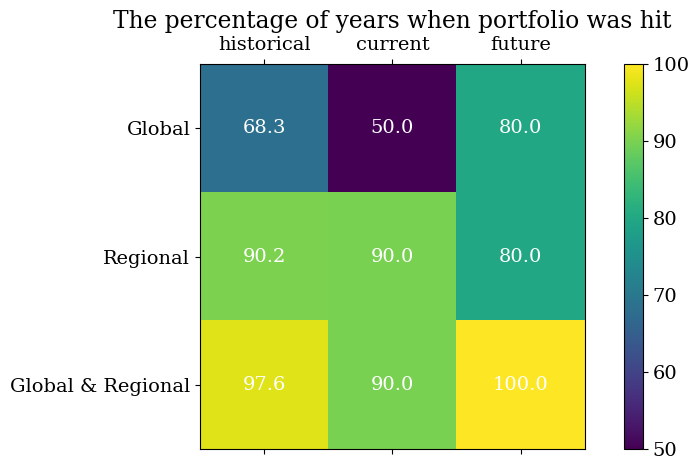

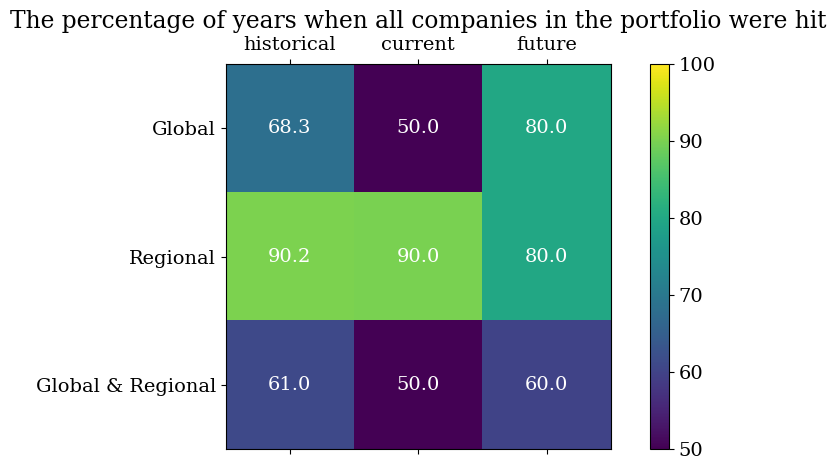

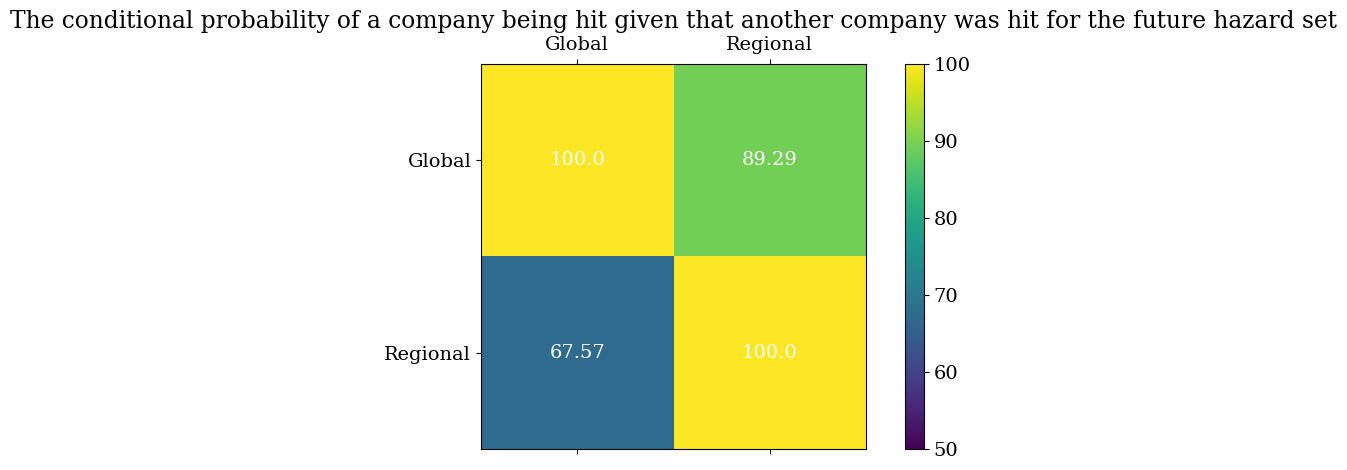

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np

import matplotlib.pyplot as plt

vmin = 50
vmax = 100

# Create the first figure
fig1, ax1 = plt.subplots(figsize=(10, 5))
cax1 = ax1.matshow(rounded_prct_portfolio_hit_df, cmap='viridis', vmin=vmin, vmax=vmax)
fig1.colorbar(cax1, ax=ax1)
ax1.set_title("The percentage of years when portfolio was hit")
ax1.set_xticks(range(len(rounded_prct_portfolio_hit_df.columns)))
ax1.set_xticklabels(rounded_prct_portfolio_hit_df.columns)
ax1.set_yticks(range(len(rounded_prct_portfolio_hit_df.index)))
ax1.set_yticklabels(rounded_prct_portfolio_hit_df.index)
# Add the values to the plot
for i in range(len(rounded_prct_portfolio_hit_df.index)):
    for j in range(len(rounded_prct_portfolio_hit_df.columns)):
        ax1.text(j, i, rounded_prct_portfolio_hit_df.iloc[i, j], ha='center', va='center', color='w')

# Create the second figure
fig2, ax2 = plt.subplots(figsize=(10, 5))
cax2 = ax2.matshow(rounded_prct_years_mutual_df, cmap='viridis', vmin=vmin, vmax=vmax)
fig2.colorbar(cax2, ax=ax2)
ax2.set_title("The percentage of years when all companies in the portfolio were hit")
ax2.set_xticks(range(len(rounded_prct_years_mutual_df.columns)))
ax2.set_xticklabels(rounded_prct_years_mutual_df.columns)
ax2.set_yticks(range(len(rounded_prct_years_mutual_df.index)))
ax2.set_yticklabels(rounded_prct_years_mutual_df.index)
# Add the values to the plot
for i in range(len(rounded_prct_years_mutual_df.index)):
    for j in range(len(rounded_prct_years_mutual_df.columns)):
        ax2.text(j, i, rounded_prct_years_mutual_df.iloc[i, j], ha='center', va='center', color='w')

# Create the third figure
fig3, ax3 = plt.subplots(figsize=(10, 5))
cax3 = ax3.matshow(rounded_conditional_prob_df[time_periods[0]], cmap='viridis', vmin=vmin, vmax=vmax)
fig3.colorbar(cax3, ax=ax3)
ax3.set_title(f"The conditional probability of a company being hit given that another company was hit for the {haz_set_temp} hazard set")
ax3.set_xticks(range(len(rounded_conditional_prob_df[time_periods[0]].columns)))
ax3.set_xticklabels(rounded_conditional_prob_df[time_periods[0]].columns)
ax3.set_yticks(range(len(rounded_conditional_prob_df[time_periods[0]].index)))
ax3.set_yticklabels(rounded_conditional_prob_df[time_periods[0]].index)
# Add the values to the plot
for i in range(len(rounded_conditional_prob_df[time_periods[0]].index)):
    for j in range(len(rounded_conditional_prob_df[time_periods[0]].columns)):
        ax3.text(j, i, rounded_conditional_prob_df[time_periods[0]].iloc[i, j], ha='center', va='center', color='w')

plt.show()


# Risk metrics – VaR ad Expecetd Shortfall

### Get the portfolio weights for each strategy (except optimal) 

In [ ]:
# Begin by defining the portfolio compositions
portfolio_strategies = cpny_combos + [['Optimal']]
portfolio_strategies = [', '.join(comb[:-1]) + ' & ' + comb[-1] if len(comb) > 1 else comb[0] for comb in portfolio_strategies]

# Define the data frame
portfolio_weights_base_df = pd.DataFrame({'Company combinations': portfolio_strategies})

# Add the columns for the companies
for cpny in companies:
    portfolio_weights_base_df[cpny] = np.zeros(len(portfolio_strategies))

# Count the number of companies in each portfolio and devide the value by the number of companies
for i, cpny_combo in enumerate(cpny_combos):
    if cpny_combo == ['Optimal']:
        portfolio_weights_base_df.loc[i, companies] = np.nan
    else:
        n_cpny = len(cpny_combo)
        for cpny in cpny_combo:
            portfolio_weights_base_df.loc[i, cpny] = 1/n_cpny

# Print the portfolio weights
print(" The portfolio weights")
print(tabulate.tabulate(portfolio_weights_base_df, headers='keys', tablefmt='pretty'))
print("\n")


 The portfolio weights
+---+----------------------+--------+----------+
|   | Company combinations | Global | Regional |
+---+----------------------+--------+----------+
| 0 |        Global        |  1.0   |   0.0    |
| 1 |       Regional       |  0.0   |   1.0    |
| 2 |  Global & Regional   |  0.5   |   0.5    |
| 3 |       Optimal        |  0.0   |   0.0    |
+---+----------------------+--------+----------+




### Simulate replacements costs ( for the risk metrics we do not use the historical year set)

In [ ]:
# Generate the sampled impacts for the historical hazard set
imp_per_year_dict, sampling_vect_dict = generate_sampled_imp_per_year(imp_dict, n_sampled_years=n_years) # Here we do not use the historical yearsets

## Expected shortfall

### Make a function to calc expected shortfall

In [ ]:
# Make a function that calculates the expected shortfall and value at risk for a portfolio of companies
def calc_var_es_port(cpny_weights, sim_costs, denominators, alpha, var=None):
    # Calculate the portfolio losses
    sim_cpny_losses = -1*cpny_weights*sim_costs/denominators
    sim_port_losses = np.sum(sim_cpny_losses, axis=1)
    # Calculate the value at risk
    if var is None:
        var = np.quantile(sim_port_losses, alpha)
    # Calculate the expected shortfall
    es = np.mean(sim_port_losses[sim_port_losses <= var])
    # Calculate the risk attribution
    risk_attribution = np.mean(sim_cpny_losses[sim_port_losses <= var], axis=0)
    return var, es, risk_attribution

# Make an example of how to use the function
# Define the portfolio weights all companies have the same weight 
cpny_weights = np.ones(len(companies))/len(companies)
# Define the simulated costs
sim_costs = imp_per_year_dict['historical']['gross'][companies].values
# Define the denominators
denominators = np.ones(len(companies))
# Define the alpha value
alpha = 1/return_period
# Calculate the value at risk and expected shortfall
var, es, risk_attribution = calc_var_es_port(cpny_weights, sim_costs, denominators, alpha)
print(f'The value at risk is {var} and the expected shortfall is {es}')

-1*calc_var_es_port(cpny_weights, sim_costs, denominators, alpha)[0]

The value at risk is -0.05856380055254442 and the expected shortfall is -0.06365784011393805


0.05856380055254442

### Make a function to optimize the expected shortfall

In [ ]:
# Make a function that finds to optimal portfolio weights that minimizes the expected shortfall or value at risk for a given impact list

def find_optimal_portfolio_weights_var_es(sim_costs, denominators, alpha, metric = 'var'):

    # Get the number of companies
    n_cpny = np.shape(sim_costs)[1]

    # Define the objective function
    if metric == 'var':
        # Define the objective function
        def objective(cpny_weights, sim_costs, denominators, alpha):
            return -1*calc_var_es_port(cpny_weights, sim_costs, denominators, alpha)[0]
    elif metric == 'es':
        # Define the objective function
        def objective(cpny_weights, sim_costs, denominators, alpha):
            return -1*calc_var_es_port(cpny_weights, sim_costs, denominators, alpha)[1]

    # Define the constraints
    def constraint1(cpny_weights):
        return np.sum(cpny_weights) - 1

    def constraint2(cpny_weights):
        return cpny_weights

    # Define the initial guess
    initial_guess = np.ones(n_cpny) / n_cpny

    # Define the bounds
    bounds = [(0, 1) for i in range(n_cpny)]

    # Define the constraints
    constraints = [{'type': 'eq', 'fun': constraint1},
                   {'type': 'ineq', 'fun': constraint2}]

    # Find the optimal portfolio weights
    opt_res = minimize(objective, initial_guess, args=(sim_costs, denominators, alpha), method='SLSQP', bounds=bounds, constraints=constraints)

    # Return the optimal portfolio weights
    return opt_res.x

# Try the function
# Define the simulated costs
sim_costs = imp_per_year_dict['historical']['gross'][companies].values
# Define the denominators
denominators = np.ones(len(companies))
# Define the alpha value
alpha = 1/return_period
# Find the optimal portfolio weights for the value at risk
optimal_weights_var = find_optimal_portfolio_weights_var_es(sim_costs, denominators, alpha, metric = 'es')
print(f'The optimal portfolio weights for the value at risk are {optimal_weights_var}')
# Print the optimal portfolio weights and the value at risk and 
var, es, risk_attribution = calc_var_es_port(optimal_weights_var, sim_costs, denominators, alpha)
print(f'The value at risk is {var} and the expected shortfall is {es}')
print(f'The risk attribution is {risk_attribution}')

The optimal portfolio weights for the value at risk are [0.18530545 0.81469455]
The value at risk is -0.030559813495709125 and the expected shortfall is -0.03583391533970584
The risk attribution is [-0.00676098 -0.02907294]


### Make a function to calc return period

In [ ]:
# Make a function that calculates the return period and aai for a given impact list and portfolio weights
def calc_imp_metric(cpny_weights, imp_list, denominators, return_period = n_years):
    imp_port = copy.deepcopy(imp_list[0]) # gives the relative change in impact
    imp_port.at_event = np.zeros(len(imp_port.at_event))
    imp_port.aai_agg = 0.0000000
    for idx, imp in enumerate(imp_list):
        imp_port.at_event += imp.at_event*cpny_weights[idx] / denominators[idx]
        imp_port.aai_agg = imp_port.aai_agg*cpny_weights[idx] / denominators[idx]

    port_freq_curve = imp_port.calc_freq_curve(return_per=np.array([return_period]))
    port_aai_agg = imp_port.aai_agg  # Return period in prct of the total asset value
    
    return port_freq_curve.impact[0], port_aai_agg


### Create a base results data frame to store data

In [ ]:
base_results_df = pd.DataFrame({'Company combinations': portfolio_strategies})

# Add the time periods as columns
VaR_cols = [time + '_VaR' for time in time_periods]
ES_cols = [time + '_ES' for time in time_periods]
RP_cols = [time + '_RP' for time in time_periods]
result_cols = RP_cols + VaR_cols + ES_cols
for time in result_cols:
    base_results_df[time] = 0.0


# Create the base results dictionaries
results_dict = {result_type: {'gross': base_results_df.copy(), 'net': base_results_df.copy()} for result_type in ['abs', 'rel'] }

# Create the base weights dictionary 
weights_dict = {
    result_type: {
        'gross': {time: portfolio_weights_base_df.copy() for time in time_periods},
        'net': {time: portfolio_weights_base_df.copy() for time in time_periods}
    } for result_type in ['abs', 'rel']
}

# Create the base risk attribution dictionary
risk_attr_base_df = portfolio_weights_base_df.copy()
risk_attr_base_df.loc[:, risk_attr_base_df.columns != 'Company combinations'] = 0 # Make all cells zero

es_risk_attr_dict = { result_type: {
                            'gross': {time: risk_attr_base_df.copy() for time in time_periods},
                            'net': {time: risk_attr_base_df.copy() for time in time_periods}
                        } for result_type in ['abs', 'rel']
                    }

### Calc the perfomance for each strategy

In [ ]:
# denominators
tot_cpny_values = [asset_tot_value_dict[cpny] for cpny in companies]

# Loop over the time periods and impact types from the imp_dict
for time, imp_type_dict in imp_dict.items():
    for imp_type, cpny_dict in imp_type_dict.items():
        # Get the impact objects for the portfolio strategy
        sim_imp_per_year = imp_per_year_dict[time][imp_type]
        imp_list =  [imp_dict[time][imp_type][cpny] for cpny in companies]

        # Calculate the ...
        for port_strat_idx in portfolio_weights_base_df.index:
            # If optimal calc the optimal portfolio
            if 'Optimal' in portfolio_weights_base_df.loc[port_strat_idx, 'Company combinations']:
                # Get the optimal portfolio strategy
                weights_abs = find_optimal_portfolio_weights_var_es(sim_imp_per_year[companies].values,  np.ones(len(companies)), alpha, metric = 'es')
                #weights_rel = find_optimal_portfolio_weights_var_es(sim_imp_per_year[companies].values,tot_cpny_values, alpha, metric = 'es')
                # Store the weights
                weights_dict['abs'][imp_type][time].loc[port_strat_idx, companies] = weights_abs
                #weights_dict['rel'][imp_type][time].loc[port_strat_idx, companies] = weights_rel
            else:
                # Get the portfolio strategy
                weights_abs = portfolio_weights_base_df.loc[port_strat_idx, companies].values
                # weights_rel = weights_abs

            # Calculate the portfolio ES (absolute and relative)
            var_abs, es_abs, risk_attr_abs = calc_var_es_port(weights_abs, sim_imp_per_year[companies].values, np.ones(len(companies)), alpha)
            # var_rel, es_rel = calc_var_es_port(weights_rel, sim_imp_per_year[companies].values, tot_cpny_values, alpha)

            # Calculate the return period (absolute and relative) and
            rp_abs, _ = calc_imp_metric(weights_abs, imp_list, list(np.ones(len(companies))), return_period)
            # rp_rel, _ = calc_imp_metric(weights_rel, imp_list, tot_cpny_values, return_period)

            # Total indirect exposure
            tot_indirect_exp = np.sum(weights_abs*tot_cpny_values)


            # Store the results
            # Absolute
            results_dict['abs'][imp_type].loc[port_strat_idx, time + '_VaR'] = -1* np.round(var_abs, 2) 
            results_dict['abs'][imp_type].loc[port_strat_idx, time + '_ES'] = -1*np.round(es_abs, 2) 
            results_dict['abs'][imp_type].loc[port_strat_idx, time + '_RP'] = np.round(rp_abs, 2) 
            # Relative
            results_dict['rel'][imp_type].loc[port_strat_idx, time + '_VaR'] =  -1*np.round(var_abs/tot_indirect_exp*100, 2)
            results_dict['rel'][imp_type].loc[port_strat_idx, time + '_ES'] = -1*np.round(es_abs/tot_indirect_exp*100, 2)
            results_dict['rel'][imp_type].loc[port_strat_idx, time + '_RP'] = np.round(rp_abs/tot_indirect_exp*100, 2)

            # Store the risk attribution
            es_risk_attr_dict['abs'][imp_type][time].loc[port_strat_idx, companies] = -1*risk_attr_abs
            es_risk_attr_dict['rel'][imp_type][time].loc[port_strat_idx, companies] = -1*risk_attr_abs/tot_indirect_exp*100
            

### Print the results

In [ ]:
# Print the results for the absolute and relative  ES gross and net for the different portfolio strategies for each time period
for imp_type in imp_types:
    print(f' For {imp_type.upper()} and ABSOLUTE risk for the different portfolio strategies for each time period')
    print(tabulate.tabulate(results_dict['abs'][imp_type], headers='keys', tablefmt='pretty'))
    print("\n")    
    print(f' For {imp_type.upper()} and RELATIVE risk for the different portfolio strategies for each time period')
    print(tabulate.tabulate(results_dict['rel'][imp_type], headers='keys', tablefmt='pretty'))
    print("\n")
    # print the portfolio weights
    for time in time_periods:
        # Print the portfolio weights
        print(f' The weights {imp_type.upper()} and ABSOLUTE risk for the different portfolio strategies for the {time} time period')
        print(tabulate.tabulate(weights_dict['abs'][imp_type][time], headers='keys', tablefmt='pretty'))
        #print(f' The weights {imp_type.upper()} and RELATIVE risk for the different portfolio strategies for the {time} time period')
        #print(tabulate.tabulate(weights_dict['rel'][imp_type][time], headers='keys', tablefmt='pretty'))

        # Print the risk attribution
        print(f' The risk attribution {imp_type.upper()} and ABSOLUTE risk for the different portfolio strategies for the {time} time period')
        print(tabulate.tabulate(es_risk_attr_dict['abs'][imp_type][time], headers='keys', tablefmt='pretty'))
        # RELATIVE
        print(f' The risk attribution {imp_type.upper()} and RELATIVE risk for the different portfolio strategies for the {time} time period')
        print(tabulate.tabulate(es_risk_attr_dict['rel'][imp_type][time], headers='keys', tablefmt='pretty'))
        

    

 For GROSS and ABSOLUTE risk for the different portfolio strategies for each time period
+---+----------------------+---------------+------------+-----------+----------------+-------------+------------+---------------+------------+-----------+
|   | Company combinations | historical_RP | current_RP | future_RP | historical_VaR | current_VaR | future_VaR | historical_ES | current_ES | future_ES |
+---+----------------------+---------------+------------+-----------+----------------+-------------+------------+---------------+------------+-----------+
| 0 |        Global        |     0.11      |    0.11    |   0.14    |      0.11      |    0.11     |    0.15    |     0.12      |    0.16    |    0.2    |
| 1 |       Regional       |     0.03      |    0.04    |   0.05    |      0.04      |    0.05     |    0.07    |     0.04      |    0.06    |   0.09    |
| 2 |  Global & Regional   |     0.06      |    0.05    |   0.07    |      0.06      |    0.06     |    0.08    |     0.06      |    0.0

## Add the Value at Risk

### Plot the Risk Attribution

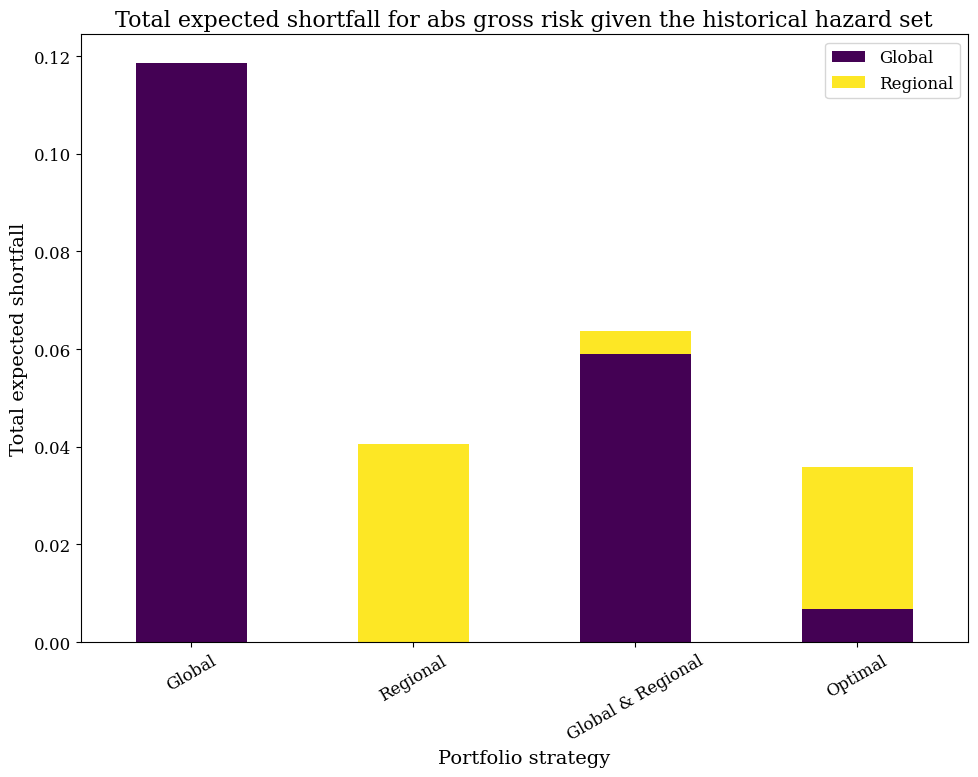

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "DejaVu Serif"
plt.rcParams["font.size"] = 14

# Parameters for the plot
time = 'historical'
risk_unit = 'abs' # abs or rel
imp_type = 'gross' # gross or net

# Get the data frame for the plot
es_plot_df = es_risk_attr_dict[risk_unit][imp_type][time].copy()
# set the company combinations as index
es_plot_df.set_index('Company combinations', inplace=True)

# Remove square brackets from index labels
es_plot_df.index = es_plot_df.index.map(lambda x: str(x).replace('[','').replace(']',''))

# Plot the results where on the x-axis we have the different portfolio strategies and on the y-axis the total expected shortfall stacked bar plot
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size here
# Plot the stacked bar plot with a better color palette
es_plot_df.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
# Set the title and labels with larger font size
ax.set_title(f'Total expected shortfall for {risk_unit} {imp_type} risk given the {time} hazard set', fontsize=16)               
ax.set_xlabel('Portfolio strategy', fontsize=14)
ax.set_ylabel('Total expected shortfall', fontsize=14)
# Rotate the x-axis labels to a smaller angle
plt.xticks(rotation=30)
# Increase the font size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=12)
# Add a legend
ax.legend(fontsize=12)
# Show the plot
plt.tight_layout()
plt.show()

# Additional - Optimal Return periods 

In [ ]:
# # Make a function that finds to optimal portfolio weights that minimizes the return period or AAI for a given impact list  

# multiplier = 100 # To make the relative optimzer convert 

# # Define the objective function
# def find_optimal_portfolio_weights_rp(imp_list, denominators, return_period = 100):

#     # Define the objective function
#     def objective(cpny_weights, imp_list, denominators, return_period):
#         return calc_imp_metric(cpny_weights, imp_list, denominators, return_period)[0]*multiplier

#     # Define the constraints
#     def constraint1(cpny_weights):
#         return np.sum(cpny_weights) - 1

#     def constraint2(cpny_weights):
#         return cpny_weights
    
#     # Get the minimal rp across all companies
#     min_rel_rp = 10000000000
#     for imp in imp_list:
#         rp_temp = imp.calc_freq_curve(return_per=np.array([return_period])).impact[0]
#         if rp_temp < min_rel_rp:
#             min_rel_rp = rp_temp
#     # Adjust the minimum rp with the multiplier
#     min_rel_rp = min_rel_rp*multiplier

#     # Define the initial guess
#     # Start with more weight to the comapny with the lowest impact 
#     aai_list = [imp.aai_agg for imp in imp_list]
#     # give the asset with the lowest impact the highest weight
#     initial_guess = [1 - aai / np.sum(aai_list) for aai in aai_list]

#     # Define the bounds
#     bounds = [(0, 1) for i in range(n_cpny)]

#     # Define the constraints where on constraint is that the sum of the weights is 1, and the other is that the weights are positive and that the objective function is min_rel_rp or less
#     constraints = [{'type': 'eq', 'fun': constraint1},
#                    {'type': 'ineq', 'fun': constraint2},
#                    {'type': 'ineq', 'fun': lambda x: min_rel_rp - objective(x, imp_list, denominators, return_period)}]                   

#     # Find the optimal portfolio weights
#     opt_res = minimize(objective, initial_guess, args=(imp_list, denominators, return_period), method='SLSQP', bounds=bounds, constraints=constraints)

#     # Return the optimal portfolio weights
#     return opt_res.x

### Optimize the portfolio weights

In [ ]:

# base_results_df = pd.DataFrame({'Company combinations': portfolio_strategies})

# # Add the time periods as columns
# for time in time_periods:
#     base_results_df[time] = 0.0

# # Compute the EAI and RP for each company and portfolio strategy
# rp_abs_dict = {'gross': base_results_df.copy(), 'net': base_results_df.copy()} # Store the absolute EAI in a dictionary
# rp_rel_dict = copy.deepcopy(rp_abs_dict) # Store the relative RP in a dictionary

# # Get the portfolio weights for the different strategies
# rp_rel_weights_dict = {imp_type: {time: portfolio_weights_base_df.copy() for time in time_periods} for imp_type in imp_types}
# rp_abs_weights_dict = copy.deepcopy(rp_rel_weights_dict)
    
# # denominators
# tot_cpny_values = [asset_tot_value_dict[cpny] for cpny in companies]

# # Loop over the time periods and impact types from the imp_dict
# for time, imp_type_dict in imp_dict.items():
#     for imp_type, cpny_dict in imp_type_dict.items():
#         # Get the impact objects for the portfolio strategy
#         imp_list = [imp_dict[time][imp_type][cpny] for cpny in companies]
#         for port_strat_idx in portfolio_weights_base_df.index:
#             # If optimal calc the optimal portfolio
#             if 'Optimal' in portfolio_weights_base_df.loc[port_strat_idx, 'Company combinations']:
#                 # Get the optimal portfolio strategy
#                 rp_rel_weights_dict[imp_type][time].loc[port_strat_idx, companies] = find_optimal_portfolio_weights_rp(imp_list, tot_cpny_values, return_period)
#                 rp_abs_weights_dict[imp_type][time].loc[port_strat_idx, companies] = find_optimal_portfolio_weights_rp(imp_list, list(np.ones(len(companies))), return_period)
#                 # Calculate the portfolio impact (absolute and relative) and return period
#                 rel_rp, rel_aai = calc_imp_metric(rp_rel_weights_dict[imp_type][time].loc[port_strat_idx, companies].values, imp_list, tot_cpny_values, return_period)
#                 abs_rp, abs_aai = calc_imp_metric(rp_abs_weights_dict[imp_type][time].loc[port_strat_idx, companies].values, imp_list, list(np.ones(len(companies))), return_period)
#             else:
#                 # Get the portfolio strategy
#                 weights = portfolio_weights_base_df.loc[port_strat_idx, companies].values
#                 # Calculate the portfolio impact (absolute and relative) and return period
#                 rel_rp, rel_aai = calc_imp_metric(weights, imp_list, tot_cpny_values, return_period)
#                 abs_rp, abs_aai = calc_imp_metric(weights, imp_list, np.ones(len(companies)), return_period)
                
#             # Store the absolute and relative EAI and RP in a dictionary
#             rp_abs_dict[imp_type].loc[port_strat_idx, time] = abs_rp
#             rp_rel_dict[imp_type].loc[port_strat_idx, time] = rel_rp * 100



In [ ]:
# # Print the results for the absolute and relative  RP gross and net for the different portfolio strategies for each time period
# for imp_type in imp_types:
#     print(f' The absolute RP {imp_type} for the different portfolio strategies for each time period')
#     print(tabulate.tabulate(rp_abs_dict[imp_type], headers='keys', tablefmt='pretty'))
#     print("\n")
#     print(f" The relative RP for the {imp_type} impact type")
#     print(tabulate.tabulate(rp_rel_dict[imp_type], headers='keys', tablefmt='pretty'))
#     print("\n")
#     # print the portfolio weights
#     for time in time_periods:
#         print(f' The weights for the absolute RP {imp_type} for the different portfolio strategies for the {time} time period')
#         print(tabulate.tabulate(rp_abs_weights_dict[imp_type][time], headers='keys', tablefmt='pretty'))
#         print("\n")
#         print(f' The weights for the relative RP {imp_type} for the different portfolio strategies for the {time} time period')
#         print(tabulate.tabulate(rp_rel_weights_dict[imp_type][time], headers='keys', tablefmt='pretty'))
#         print("\n")